In [42]:
from __future__ import division
from matplotlib.pyplot import imshow

import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from datetime import datetime
from mxnet.gluon.data.vision import transforms
from skimage import util

from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, TrainingHistory, viz
from gluoncv.data import transforms as gcv_transforms
print("Imports successful")

Imports successful


In [37]:
# number of GPUs to use
num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]

default_init = True

net = get_model('cifar_resnet56_v1', classes=100)
if default_init:
    net.initialize(mx.init.Xavier(), ctx = ctx)
else:
    net.initialize(mx.init.MSRAPrelu(), ctx=ctx)
    print("Using MSRA Prelu Init.")
print("Model Init Done.")

Model Init Done.


In [38]:
resize = 32
mean_rgb = [0.485, 0.456, 0.406]
std_rgb = [0.229, 0.224, 0.225]
max_aspect_ratio = 4.0 / 3.0
min_aspect_ratio = 3.0 / 4.0
max_random_area = 1
min_random_area = 0.08
jitter_param = 0.4
lighting_param = 0.1

transform_train = transforms.Compose([    
#     transforms.RandomResizedCrop(resize,
#                                  scale=(min_random_area, max_random_area), 
#                                  ratio=(min_aspect_ratio, max_aspect_ratio)),
    
        # Randomly flip the image horizontally
    transforms.RandomFlipLeftRight(),
    
    transforms.RandomBrightness(brightness=jitter_param),
    transforms.RandomSaturation(saturation=jitter_param),
    transforms.RandomHue(hue=jitter_param),
    
    transforms.RandomLighting(lighting_param),
    
    # Randomly crop an area and resize it to be 32x32, then pad it to be 40x40
    gcv_transforms.RandomCrop(32, pad=4),
        
    # Transpose the image from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    transforms.ToTensor(),
    
    # Normalize the image with mean and standard deviation calculated across all images
    transforms.Normalize(mean_rgb, std_rgb),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_rgb, std_rgb),
])
print("Preprocessing Step Successful.")

Preprocessing Step Successful.


In [39]:
# Batch Size for Each GPU
per_device_batch_size = 256

# Number of data loader workers
num_workers = 2

# Calculate effective total batch size
batch_size = per_device_batch_size * num_gpus

# Set train=True for training data
# Set shuffle=True to shuffle the training data
train_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR100(train=True).transform_first(transform_train),
    batch_size=batch_size, 
    shuffle=True, 
    last_batch='discard', 
    num_workers=num_workers)

# Set train=False for validation data
# Set shuffle=False to shuffle the testing data
val_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR100(train=False).transform_first(transform_test),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers)
print("Initialization of train_data and val_data successful.")
print("Per Device Batch Size: {}".format(per_device_batch_size))

Initialization of train_data and val_data successful.
Per Device Batch Size: 256


0
(256, 3, 32, 32)
<class 'mxnet.ndarray.ndarray.NDArray'>
(32, 32, 3)
<class 'mxnet.ndarray.ndarray.NDArray'>


MXNetError: Traceback (most recent call last):
  File "src/operator/contrib/../tensor/./../mxnet_op.h", line 738
MXNetError: Check failed: from.Size() == to.Size() (786432 vs. 3072) : 

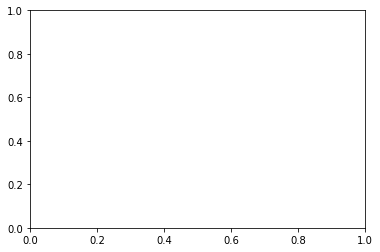

In [40]:
for i, batch in enumerate(val_data):
    data  = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
    label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
    # Transpose the image from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    print(i)
    print(data[0].shape)
    print(type(data[0]))
    temp_data = nd.reshape(data[0], (32, 32, 3))
    print(temp_data.shape)
    print(type(temp_data[0]))
    viz.plot_image(temp_data)
    if i == 3:
        break